# Lab3: Homography, RANSAC, and Fundemental Matrix

We have gone through filtering, feature detection and description last week. For this week, we are gonna make attampts on using the extracted features to align images from planar scene for generating panaroma, triangulate world points in 3D, and estimating camera pose.


### At the moment this jupyter notebook only contain the first half of the lab sessions and the other half will be released before the next lab session.


## Part 1: Image Transformation

## Task 1: Image Transformations
Your first task is rather simple and just requires you to run an example.
The idea is just to show you a beneficial use of applying affine or perspective transformations to images and how this could be used in practice.

First load and show the images:


In [1]:
import numpy as np
import copy
import cv2
import matplotlib
from matplotlib import pyplot as plt
import random
import copy
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

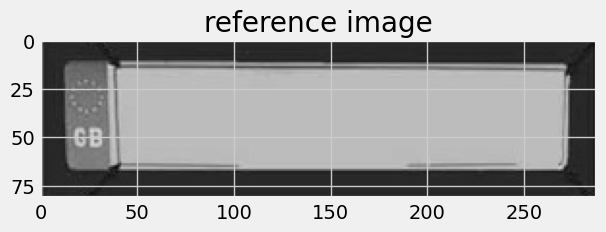

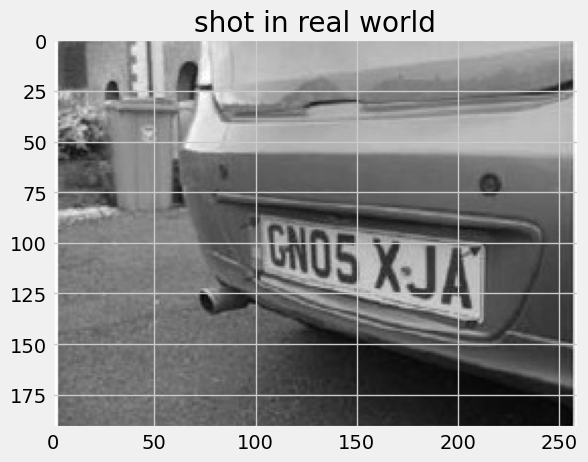

In [2]:
# Load images
tag_img = cv2.imread('../dataset/plate_side.jpg')
tag_img = cv2.cvtColor(tag_img, cv2.COLOR_BGR2GRAY)

ref_img = cv2.imread('../dataset/reference.jpg')
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)


plt.figure()
plt.title("reference image")
plt.imshow(ref_img, 'gray')
# JINGWEN: I can't run this...
# Locate points of the documents or object which you want to transform into
# ref_pts = plt.ginput(4)
plt.show()

# Locate points of the documents or object which you want to transform
plt.figure()
plt.title("shot in real world")
plt.imshow(tag_img, 'gray')
# tag_pts = plt.ginput(4)
plt.show()

The goal is to compute the 2D affine transformation that maps points from the source frame to the reference frame. The affine transformation consists of a linear transformation (rotation, scaling, and shearing) and a translation, requiring six degrees of freedom (6-DoF). We need at least 3 correspondences to solve this. We can get least squre solution if more than 3 pair of correspondences are given.

$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}a_{11} & a_{12} \\ a_{21} & a_{22}\end{bmatrix} \begin{bmatrix}x^{\prime} \\ y^{\prime}\end{bmatrix} + \begin{bmatrix}t_1 \\ t_2\end{bmatrix}
$$

In [3]:


# We could use the following 4 points:
ref_pts = np.array([[11.8, 11.0],
                    [270.9, 13.1],
                    [270.9, 67.9],
                    [14.9, 67.4]])  # [4, 3]: top-left, top-right, bottom-right, bottom-left

tag_pts = np.array([[95.6, 84.0],
                    [211.6, 101.3],
                    [211.1, 141.3],
                    [97.6, 112.2]])

Y = ref_pts.transpose(1, 0)  # [2, N]
X = tag_pts.transpose(1, 0)  # [2, N]
X = np.concatenate([X, np.ones((1, 4))], axis=0)  # [3, N]

## Task1.1: Call OpenCV function as reference result

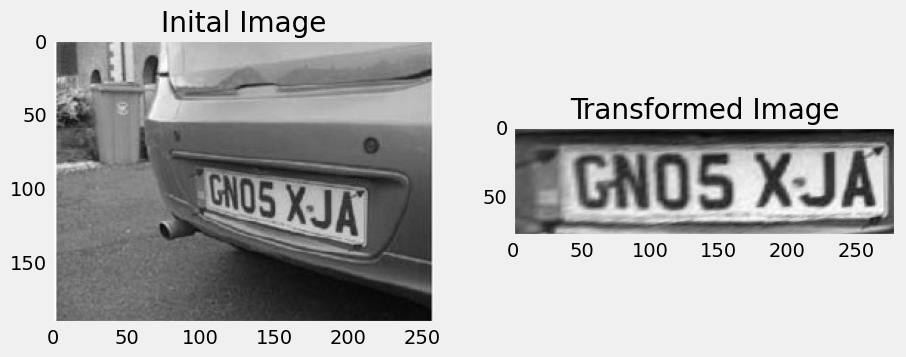

Solved transform matrix:
[[ 5.33962992e+00 -2.13089797e-01 -4.74046561e+02]
 [-3.51693314e-01  3.13291883e+00 -2.12276557e+02]
 [ 6.79228821e-03 -9.48079999e-04  1.00000000e+00]] 

Transformed points before de-homogenising:
[[ 18.52251562 634.23313251 623.03972566  23.19264316]
 [ 17.26674366  30.66981496 156.16241466 104.91166793]
 [  1.56970403   2.34120768   2.29988834   1.55655275]] 

Transformed points after de-homogenising:
[[ 11.80000511 270.89998786 270.89998915  14.90000459]
 [ 10.99999955  13.09999758  67.8999985   67.40000793]
 [  1.           1.           1.           1.        ]]


In [4]:
# switch to inline plot and we can see plots in the notebook
%matplotlib inline

# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(np.float32(tag_pts), np.float32(ref_pts))
result = cv2.warpPerspective(tag_img, matrix, (280, 80))
# Wrap the transformed image

# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(result, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix:")
print(matrix, "\n")
Y_ = matrix @ X
print("Transformed points before de-homogenising:")
print(Y_, "\n")
Y_ /= Y_[2, :]
print("Transformed points after de-homogenising:")
print(Y_)

## Task1.2: Solve affine matrix using least square.

Next, we solve the $2\times3$ affine matrix with our own solver based on standard-form least-square:

$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}a_{11} & a_{12} & t_1 \\ a_{21} & a_{22} & t_2\end{bmatrix} \begin{bmatrix}x^{\prime} \\ y^{\prime} \\ 1\end{bmatrix}
$$

$$
\mathbf{y} = \mathbf{A} \mathbf{x}, \quad \text{where} \quad \mathbf{x} \in \mathbb{R}^{D_1}, \mathbf{y} \in \mathbb{R}^{D_2}
$$

Suppose we have $N$ correspondences. We can stack the vectors:

$$
\mathbf{Y} = \mathbf{A} \mathbf{X}, \quad \text{where} \quad \mathbf{X} \in \mathbb{R}^{D_1 \times N}, \mathbf{A} \in \mathbb{R}^{D_2 \times D_1}, \mathbf{X} \in \mathbb{R}^{D_2 \times N}
$$

$\mathbf{A}$ could be solved by standard least-square:

$$
\mathbf{A} = \mathbf{Y} \mathbf{X}^T(\mathbf{X} \mathbf{X}^T)^{-1}
$$

In [5]:
#TODO Work out the affine matrix M from X and Y here:
M = Y @ X.T @ np.linalg.inv(X @ X.T)


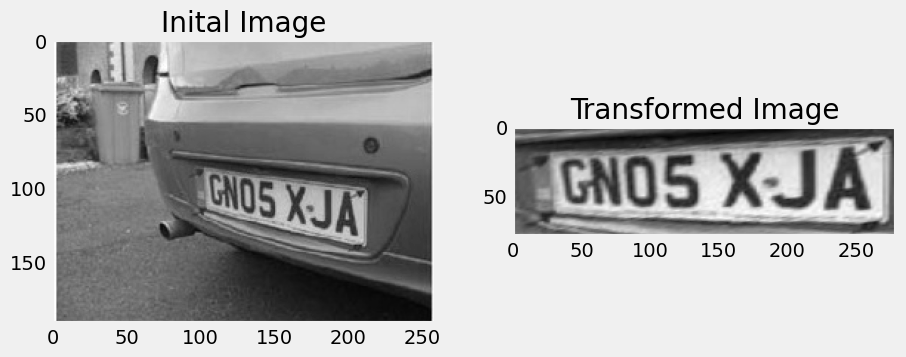

Solved transform matrix:
[[ 2.24377037e+00  2.68909214e-03 -2.03654537e+02]
 [-3.07284650e-01  1.58137510e+00 -8.63126941e+01]] 

Transformed points before de-homogenising:
[[ 11.07579471 271.39967947 270.38535797  15.63916785]
 [ 17.14640144   8.85917126  72.26781744  61.12660986]] 

Transformed points after de-homogenising:
[[ 0.64595447 30.6348835   3.74143523  0.25584877]
 [ 1.          1.          1.          1.        ]]


In [6]:


warped_2 = cv2.warpAffine(tag_img, M, (280, 80))
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(warped_2, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix:")
print(M, "\n")
Y_ = M @ X
print("Transformed points before de-homogenising:")
print(Y_, "\n")
Y_ /= Y_[1, :]
print("Transformed points after de-homogenising:")
print(Y_)

## Task1.3: Solve homography with DLT.
Finally, we solve the homography matrix (8-DoF) via DLT. DLT is to rewrite similarity equations $\mathbf{y} = \alpha\mathbf{A}\mathbf{x}$ as homogenous linear equation and solve.

$$
\begin{align}
    \begin{bmatrix}x \\ y \\ 1\end{bmatrix} = \alpha\begin{bmatrix}h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix}\begin{bmatrix}x^{\prime} \\ y^{\prime} \\ 1\end{bmatrix}
\end{align}
$$

Here we have two more DoFs and the solution is up to an unknown scale factor $\alpha$. More introduction about similarity equations and DLT can be found at: https://en.wikipedia.org/wiki/Direct_linear_transformation 

Expand the above equation and we get:

$$
\begin{align}
    x = \alpha (h_{11} x^{\prime} + h_{12} y^{\prime} + h_{13}) \\
    y = \alpha (h_{21} x^{\prime} + h_{22} y^{\prime} + h_{23}) \\
    1 = \alpha (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) \\
\end{align}
$$

Eliminate $\alpha$, we get:

$$
\begin{align}
    (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) x = (h_{11} x^{\prime} + h_{12} y^{\prime} + h_{13}) \\
    (h_{31} x^{\prime} + h_{32} y^{\prime} + h_{33}) y = (h_{21} x^{\prime} + h_{22} y^{\prime} + h_{23}) \\
\end{align}
$$

$$
\begin{align}
    h_{31} xx^{\prime} + h_{32} xy^{\prime} + h_{33}x - h_{11} x^{\prime} - h_{12} y^{\prime} - h_{13}) = 0 \\
    h_{31} yx^{\prime} + h_{32} yy^{\prime} + h_{33}y - (h_{21} x^{\prime} - h_{22} y^{\prime} - h_{23}) = 0 \\
\end{align}
$$

In matrix form:

$$
\mathbf{A}_i\mathbf{h} = \mathbf{0}
$$

$$
\mathbf{A}_i = \begin{bmatrix}-x^{\prime} & -y^{\prime} & -1 & 0 & 0 & 0 & xx^{\prime} & xy^{\prime} & x \\
0 & 0 & 0 & -x^{\prime} & -y^{\prime} & -1 & yx^{\prime} & yy^{\prime} & y
\end{bmatrix}
$$

$$
\mathbf{h} = \begin{bmatrix}h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33}\end{bmatrix}^T
$$

This is a total least squares minimization problem which can be solved via SVD:

$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T
$$

Choosing the last column of $\mathbf{V}$ to be $\mathbf{h}$

https://en.wikipedia.org/wiki/Singular_value_decomposition

In [7]:
# Workout homography matrix here:

##TODO First construct Ai from one point pair:
def construct_a_from_pts(ref, tag):

    ##TODO populate matrices here
    x, y = ref
    x_prime, y_prime = tag

    row1 = [-x_prime, -y_prime, -1, 0, 0, 0, x*x_prime, x * y_prime, x]
    row2 = [0, 0, 0, -x_prime, -y_prime, -1, y * x_prime, y * y_prime, y]
    Ai = np.array([row1, row2])

    return Ai

##TODO Assmble A and solve it, 
n_pts = ref_pts.shape[0]
A = np.zeros((2 * n_pts, 9))
for i in range(n_pts):
    A[2*i:2*i+2, :] = construct_a_from_pts(ref_pts[i], tag_pts[i])
    
##TODO Find V and construct M, remember normalization!
# Step 2: Perform SVD
_, _, V = np.linalg.svd(A)  # SVD decomposition

# Step 3: Extract homography matrix
M2 = V[-1, :].reshape(3, 3)  # Last row of v reshaped to 3x3 matrix



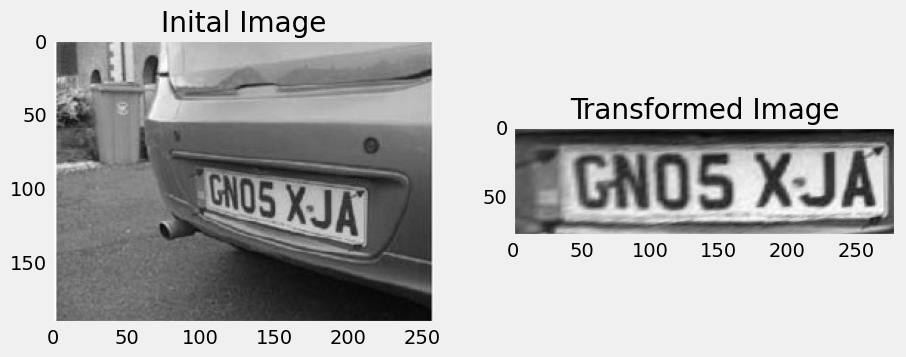

Solved transform matrix:
[[-1.02795310e-02  4.10227431e-04  9.12605651e-01]
 [ 6.77058506e-04 -6.03130455e-03  4.08661899e-01]
 [-1.30760961e-05  1.82518508e-06 -1.92513980e-03]] 

Transformed points before de-homogenising:
[[-0.03565841 -1.22098707 -1.19943821 -0.04464906]
 [-0.03324089 -0.05904367 -0.30063438 -0.20196956]
 [-0.0030219  -0.00450715 -0.00442761 -0.00299658]] 

Transformed points after de-homogenising:
[[ 11.8 270.9 270.9  14.9]
 [ 11.   13.1  67.9  67.4]
 [  1.    1.    1.    1. ]]


In [8]:


warped_dlt = cv2.warpPerspective(tag_img, M2, (280, 80))
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(warped_dlt, 'gray')
plt.grid(False)
plt.title('Transformed Image')
plt.show()

print("Solved transform matrix:")
print(M2, "\n")
Y_ = M2 @ X
print("Transformed points before de-homogenising:")
print(Y_, "\n")
Y_ /= Y_[2, :]
print("Transformed points after de-homogenising:")
print(Y_)

## Part 2 Panaroma



## Task2 
The aim of Task2 is to calculate the homography that best maps two sets of points to one another. We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes. You should use this
template for your code and fill in the missing sections marked "TO DO."


## Import libraries 

In [9]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Task 2.1 Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [10]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom)

# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1))

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

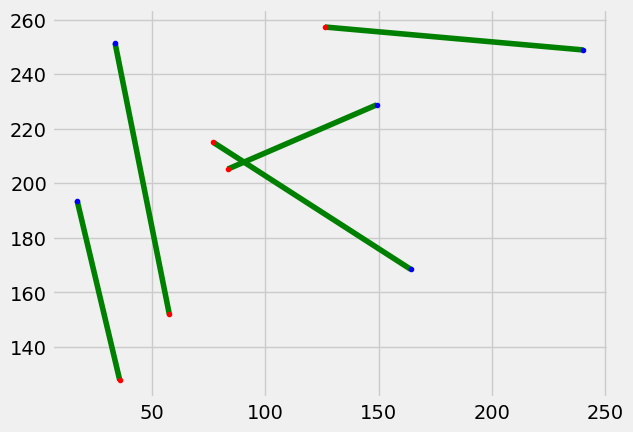

In [11]:
# Plot a green line between pairs of start points (blue) and transformed points (red).
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

## Task 2.2 Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [12]:
def construct_a_from_pts(ref, tag):

    ##TODO populate matrices here
    x, y = ref[:2]
    x_prime, y_prime = tag[:2]

    row1 = [-x_prime, -y_prime, -1, 0, 0, 0, x*x_prime, x * y_prime, x]
    row2 = [0, 0, 0, -x_prime, -y_prime, -1, y * x_prime, y * y_prime, y]
    Ai = np.array([row1, row2])

    return Ai

In [13]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Check the task above.
    # Hint: SVD will be involved. 

    #Perform SVD
    _, _, V = np.linalg.svd(A) 
    # Smallest Singular Value
    h = V[-1,:]
    
    return h

In [14]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    #TODO: replace this:
    #H = np.identity(3)

    #TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.

    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    

    # Then construct the matrix A, size (n_points * 2, 9)
    A = np.zeros((2 * n_points, 9))
    for i in range(n_points):
        A[2*i:2*i+2, :] = construct_a_from_pts(pts2Hom[:,i], pts1Hom[:,i])

    # Consult the notes!
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape(3, 3)

    # Normalize H so that H[2, 2] = 1
    if H[2, 2] != 0:
        H /= H[2, 2]

    
    
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Sqaured difference between pts2Cart and pts2EstCart is: 7.10


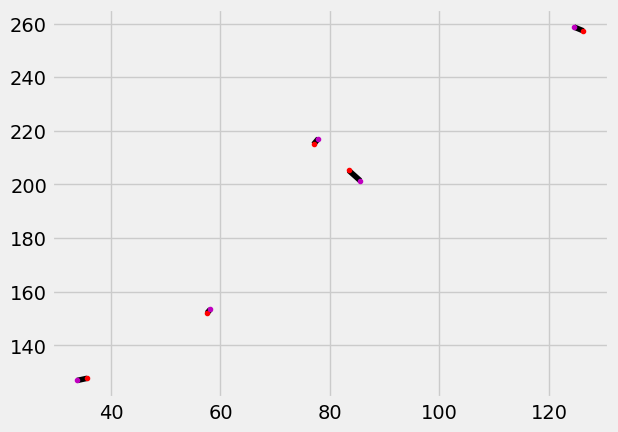

In [15]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
HEst = calcBestHomography(pts1Cart, pts2Cart)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

Sqaured difference between pts2Cart and pts2EstCart is: 7.10
Sqaured difference between pts2Cart and pts2EstCartScaled is: 7.10


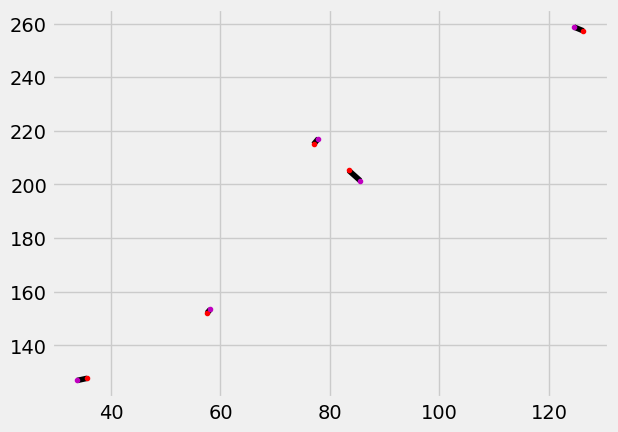

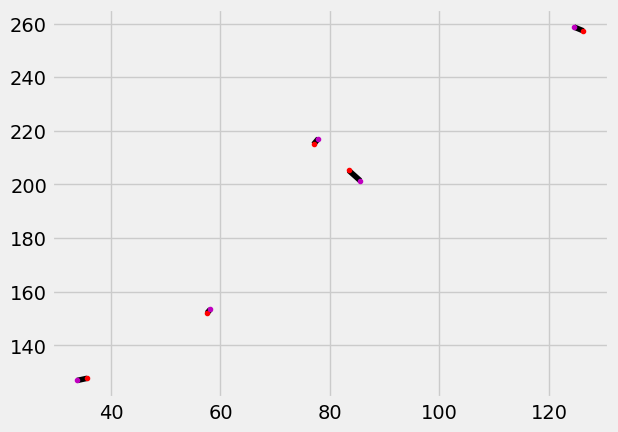

In [16]:
HEst = calcBestHomography(pts1Cart, pts2Cart)

alpha = 6.9
H_scaled = alpha * HEst

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

pts2Scaled = np.matmul(H_scaled,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))
pts2EstCartScaled = pts2Scaled[0:2,:] / np.tile([pts2Scaled[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))
sqDiff_Scaled = np.mean(sum((pts2Cart - pts2EstCartScaled)**2))


print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)
print("Sqaured difference between pts2Cart and pts2EstCartScaled is: %.2f" % sqDiff_Scaled)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCartScaled[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCartScaled[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCartScaled[0,cPoint],pts2EstCartScaled[1,cPoint],'m.') 

plt.show()



[[ 1.45758787e+01  7.87140759e+00 -9.67147540e+01]
 [-5.37081065e+00  6.42846108e-01 -1.25621214e+02]
 [ 1.41963338e-01  3.07918434e-02  1.00000000e+00]]
[[ 1.45758787e+01  7.87140759e+00 -9.67147540e+01]
 [-5.37081065e+00  6.42846108e-01 -1.25621214e+02]
 [ 1.41963338e-01  3.07918434e-02  1.00000000e+00]]
Sqaured difference between pts2Cart and pts2EstCart is: 16.96


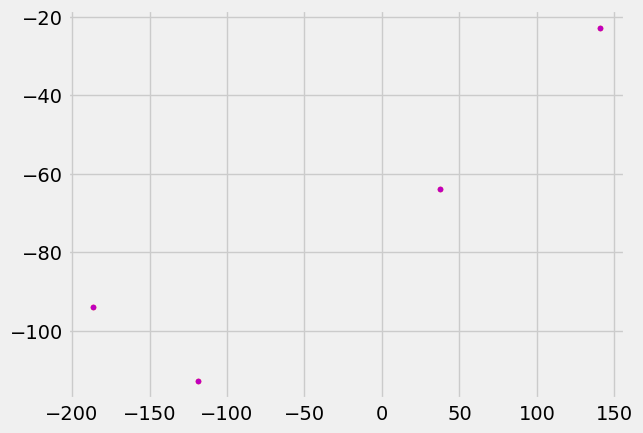

In [17]:
pts1Cart = np.random.rand(2,4) * 400 - 200
pts2Cart = np.random.rand(2,4) * 400 - 200
HEst = calcBestHomography(pts1Cart, pts2Cart)
print(HEst)

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
pts2Cart_noise = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

#print(pts2Cart)

HEst_noise = calcBestHomography(pts1Cart, pts2Cart_noise)
print(HEst)

# Apply estimated homography to points
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))
#print(pts2EstCart)

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart_noise - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)


# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()




## Task 3
It's time to build something cool! One nice application of homographies is building a simple image stitcher for making panoramas. 

You'll reuse the routines you've written in part 1A (`calcBestHomography` and `solveAXEqualsZero`) again here, so feel free to copy over your functions directly. 

We're provided with three images. One large image, `im1`, is the target, i.e. we'll somehow transform and transfer two other images, `im2` and `im3` into this one.

We need some way of knowing how `im2` and `im3` map into `im1`. To that end, we'll assume a user (or a feature matching alogorithm) provided us with a sets of paired points. One set links points in `im1` to points in `im2`. The other set links `im1` and `im3` in the same manner. To perform the stitch, we'll find two homographies using these point pairs, one to translate between the space in `im1` and the space in `im2` and the other for `im1` and `im3`. 

The end result is worth it, so don't dispair!

## Import libraries 

In [18]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import time

## Loading and plotting images 

Red points show how `im2` and `im1` are related. Magenta points explain how `im1` and `im3` are related.

__NOTE:__ Before you get caught out, notice that the point pairs are in X, Y format, not in R, C format. In this convention, X points run along columns from left to right and Y points run along rows from top to bottom.

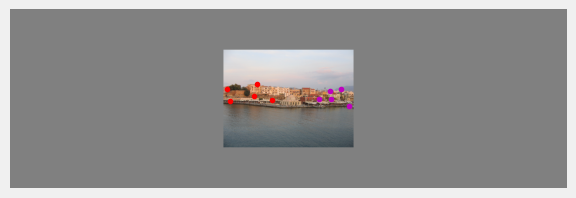

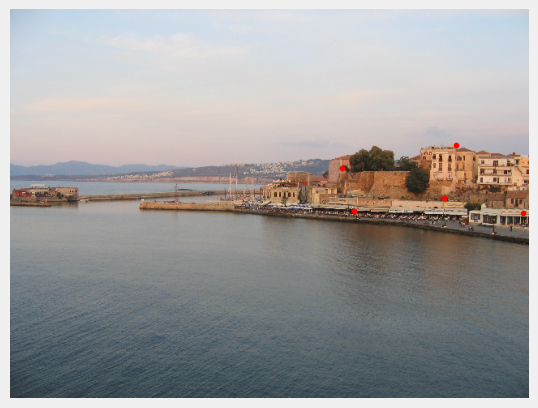

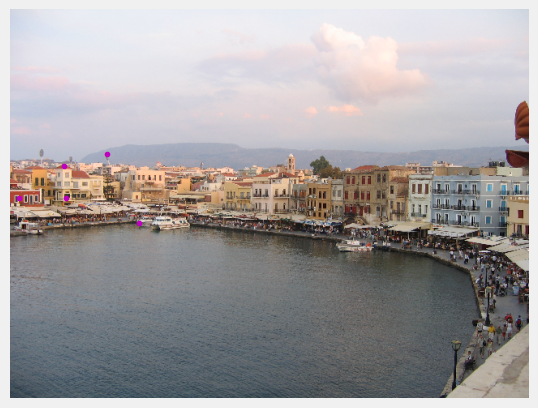

In [38]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']


# im3 is right image
im3 = data['im3']
# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

## You should copy paste these functions from task2. 

In [39]:
def construct_a_from_pts(tag, ref):
    x, y = tag[:2]
    x_, y_ = ref[:2]

    Ai = np.array([[-x_, -y_, -1, 0, 0, 0, x_ * x, x * y_, x ],
                  [0, 0, 0,-x_, -y_, -1, y * x_, y * y_, y ]])
    
    return Ai

In [40]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Check the task above.
    # Hint: SVD will be involved. 

    #Perform SVD
    _, _, V = np.linalg.svd(A) 
    # Smallest Singular Value
    h = V[-1,:]
    
    return h

In [41]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    #TODO: replace this:
    #H = np.identity(3)

    #TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.

    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    

    # Then construct the matrix A, size (n_points * 2, 9)
    A = np.zeros((2 * n_points, 9))
    for i in range(n_points):
        A[2*i:2*i+2, :] = construct_a_from_pts(pts1Hom[:,i], pts2Hom[:,i])

    # Consult the notes!
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape(3, 3)

    # Normalize H so that H[2, 2] = 1
    if H[2, 2] != 0:
        H /= H[2, 2]
    
    H = np.linalg.inv(H)
    return H

## The Process

Let's consider the first stitch, transforming and pasting `im2` into `im1`. 

We can loop over every location in `im1` and look in `im2` to see if there's a value we can paste in our image. The act of _looking_ into `im2` means that we need to translate from a location in `im1` to a location in `im2`. You can visualize this easily with the point correspondances already provided. For any other point in `im1`, we need a homography! You can use the function you've written before to generate this homography using `pts1` and `pts2`.

So now that we have a way of going from any location in `im1` to `im2`, we can loop over the locations in `im1`, get the corresponding positions in `im2` using the homography, and copy over that pixel value at each location from `im2` to `im1`.

There's one caveat, it's not always true that a transformed location from `im1` will be a valid index in `im2`, so for every index we need to check if it lies in the bounds of `im2`.

Don't worry if your solution takes a while to run. For loops aren't efficient. It might take anywhere from a minute to three for each stitch. You can make this much faster, but don't worry about that right now. 

Again, careful of how you translate between X-Y and R-C in your code when indexing; you've been warned! 

In [42]:
# TO DO: Calculate homography from pts1 to pts2 

H = calcBestHomography(pts1,pts2)

#TODO: 
# For every pixel in image 1 (two loops):
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # Make sure you round the position using np.round since you'll use it as an index to a matrix.
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1
    # 



# Create a copy of image1 to avoid modifying the original
stitched_image = np.copy(im1)

# Dimensions of the images
rows1, cols1, _ = im1.shape
rows2, cols2, _ = im2.shape

# Start timer
startTime = time.perf_counter()

# Iterate over every pixel in image1
for y1 in range(rows1):
    for x1 in range(cols1):
        # Transform the pixel (x1, y1) using the homography matrix H
        pixel_pos = np.array([x1, y1, 1])
        transformed_pos = np.dot(H, pixel_pos)

        # Convert to Cartesian coordinates
        x2 = transformed_pos[0] / transformed_pos[2]
        y2 = transformed_pos[1] / transformed_pos[2]

        # Round to nearest integer to index image2
        x2 = int(np.round(x2))
        y2 = int(np.round(y2))

        # Check if transformed position is within bounds of image2
        if 0 <= x2 < cols2 and 0 <= y2 < rows2:
            # Copy pixel colour from image2 to the corresponding position in stitched_image
            stitched_image[y1, x1] = im2[y2, x2]

# End timer
print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))
     


Stitching image 2 to image 1 took: 21.29s


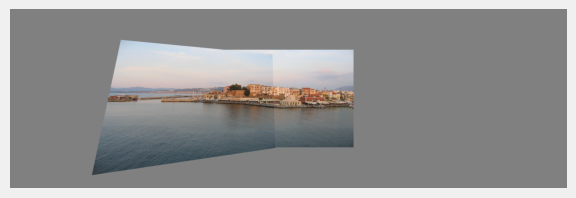

In [43]:
# Plot the intermediate panorama
plt.imshow(stitched_image)
plt.axis('off')
plt.show()

In [44]:
# TO DO: Repeat the above process mapping image 3 to image 1.

# Calculate homography from pts1b to pts3
H = calcBestHomography(pts1b,pts3)

# Dimensions of the images
rows1, cols1, _ = stitched_image.shape
rows3, cols3, _ = im3.shape

# Start timer
startTime = time.perf_counter()

# Iterate over every pixel in image1
for y1 in range(rows1):
    for x1 in range(cols1):
        # Transform the pixel (x1, y1) using the homography matrix H
        pixel_pos = np.array([x1, y1, 1])
        transformed_pos = np.dot(H, pixel_pos)

        # Convert to Cartesian coordinates
        x3 = transformed_pos[0] / transformed_pos[2]
        y3 = transformed_pos[1] / transformed_pos[2]

        # Round to nearest integer to index image2
        x3 = int(np.round(x3))
        y3 = int(np.round(y3))

        # Check if transformed position is within bounds of image2
        if 0 <= x3 < cols3 and 0 <= y3 < rows3:
            # Copy pixel colour from image2 to the corresponding position in stitched_image
            stitched_image[y1, x1] = im3[y3, x3]

# End timer
print("Stitching image 3 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 3 to image 1 took: 20.09s


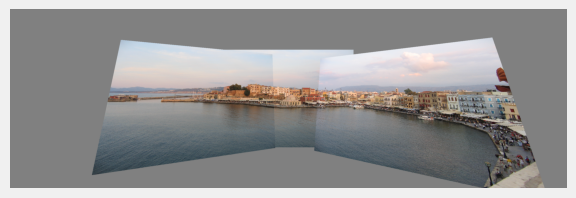

In [45]:
# Plot the final panorama
plt.imshow(stitched_image)
plt.axis('off')
plt.show()

### _Fun_ task for those who have finished all above:


Do __NOT__ do this unless you've finished all four parts, want a challenge, and an exercise in numpy and vectorization. 

For loops are slow. Can you think of ways of making it faster with vectorized code? You can definitely bring it down to at least a second per stitch and maybe even lower. Speak to the TAs if you want, but you would need to figure this out for yourself as a good exercise.

### Task: How much time did you save?


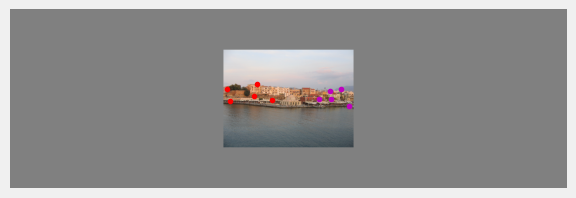

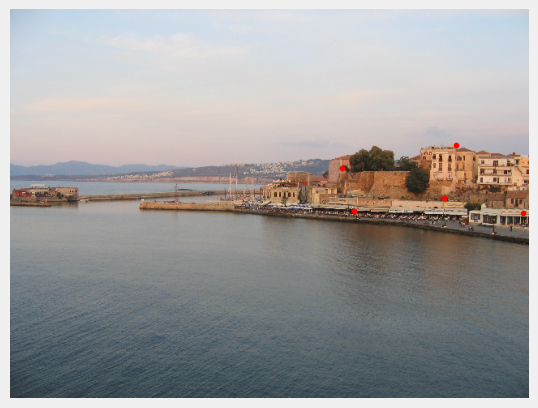

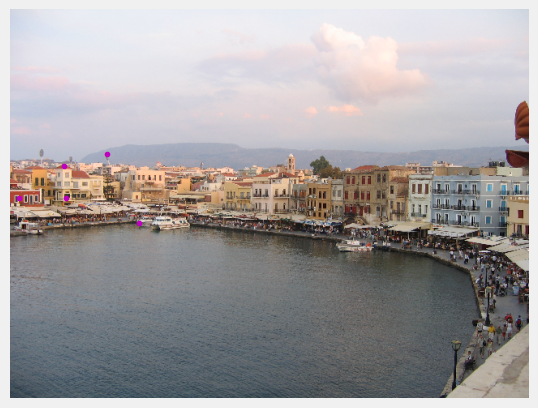

In [46]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']


# im3 is right image
im3 = data['im3']
# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

Stitching image 2 to image 1 took: 0.18s


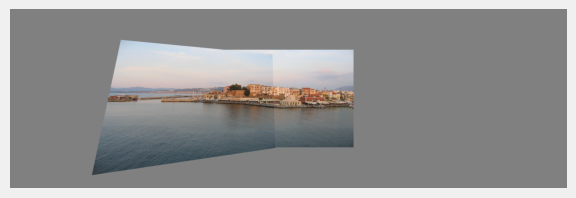

In [47]:
# TO DO: Calculate homography from pts1 to pts2 
H = calcBestHomography(pts1, pts2)

startTime = time.perf_counter()

h1, w1, _ = im1.shape
h2, w2, _ = im2.shape


y1, x1 = np.meshgrid(np.arange(h1), np.arange(w1), indexing='ij')
ones = np.ones_like(x1)
points1 = np.stack((x1.ravel(), y1.ravel(), ones.ravel()), axis=0)  # Shape (3, num_pixels)

# Transform all coordinates using H
points2_hom = H @ points1  # Apply homography
points2_hom /= points2_hom[2, :]  # Normalize by the third (homogeneous) coordinate
x2 = points2_hom[0, :].round().astype(int)  # x-coordinates in im2
y2 = points2_hom[1, :].round().astype(int)  # y-coordinates in im2

# Create a mask for valid coordinates within the bounds of im2
valid_mask = (x2 >= 0) & (x2 < w2) & (y2 >= 0) & (y2 < h2)

# Map valid coordinates back to the image
im1[y1.ravel()[valid_mask], x1.ravel()[valid_mask]] = im2[y2[valid_mask], x2[valid_mask]]

print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

plt.imshow(im1)
plt.axis('off')
plt.show()

Stitching image 3 to image 1 took: 0.17s


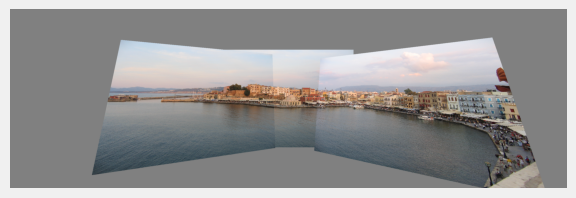

In [48]:
# TO DO: Calculate homography from pts1 to pts3 
H = calcBestHomography(pts1b, pts3)

startTime = time.perf_counter()

h1, w1, _ = im1.shape
h3, w3, _ = im3.shape


y1, x1 = np.meshgrid(np.arange(h1), np.arange(w1), indexing='ij')
ones = np.ones_like(x1)
points1 = np.stack((x1.ravel(), y1.ravel(), ones.ravel()), axis=0)  # Shape (3, num_pixels)

# Transform all coordinates using H
points3_hom = H @ points1  # Apply homography
points3_hom /= points3_hom[2, :]  # Normalize by the third (homogeneous) coordinate
x3 = points3_hom[0, :].round().astype(int)  # x-coordinates in im3
y3 = points3_hom[1, :].round().astype(int)  # y-coordinates in im3

# Create a mask for valid coordinates within the bounds of im3
valid_mask = (x3 >= 0) & (x3 < w3) & (y3 >= 0) & (y3 < h3)

# Map valid coordinates back to the image
im1[y1.ravel()[valid_mask], x1.ravel()[valid_mask]] = im3[y3[valid_mask], x3[valid_mask]]

print("Stitching image 3 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

plt.imshow(im1)
plt.axis('off')
plt.show()

Now, finalize and encapsule your implementation of sticking image together to a funciton for later use, vectorised stiching will save you a lot of time for the later tasks.


In [49]:
def stitch_image(im1, im2, H, direction='left'):
    """Stitch im2 into im1 using homography H"""
    # the direction argument is for logging only.
    startTime = time.perf_counter()
    
    
    #TODO Actual Stiching
    rows1, cols1, _ = im1.shape
    rows2, cols2, _ = im2.shape
    y1, x1 = np.meshgrid(np.arange(rows1), np.arange(cols1), indexing = "ij")
    ones = np.ones_like(x1)

    points1 = np.stack((x1.ravel(), y1.ravel(), ones.ravel()), axis=0)  # Shape (3, num_pixels)
    # Transform all coordinates using H
    points2_hom = H @ points1  # Apply homography
    points2_hom /= points2_hom[2, :]  # Normalize by the third (homogeneous) coordinate
    x2 = points2_hom[0, :].round().astype(int)  # x-coordinates in im2
    y2 = points2_hom[1, :].round().astype(int)  # y-coordinates in im2

    # Create a mask for valid coordinates within the bounds of im2
    valid_mask = (x2 >= 0) & (x2 < cols2) & (y2 >= 0) & (y2 < rows2)

    # Map valid coordinates back to the image
    im1[y1.ravel()[valid_mask], x1.ravel()[valid_mask]] = im2[y2[valid_mask], x2[valid_mask]]

                    
    print(f"Stitching {direction} image took: {time.perf_counter() - startTime:.2f}s")
    return im1

## Task 4: Panorama Stitching with RANSAC

RANSAC (Random Sample Consensus) is an iterative algorithm for robust model estimation:
1. Randomly select minimum number of points needed (4 points for homography)
2. Calculate model (homography) using these points
3. Count how many other points agree with this model (inliers)
4. Repeat steps 1-3 many times
5. Keep the model with the most inliers

This helps remove incorrect matches (outliers) that would distort our homography estimation.

### Let's implement this step by step:

In [50]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

In [51]:
#### Common Functions
def resize_image(image):
    target_width = 1280
    target_height = 800
    resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_AREA)
    return resized_image

def load_and_convert_image(img):
    """Convert image to grayscale and RGB formats"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    return img_gray, img_rgb

def detect_and_match(img1_gray, img2_gray, max_features=1000, ratio_thresh=0.7):
    """Detect SIFT features and match between two images"""
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=max_features)
    
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    
    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            
    return kp1, kp2, good_matches

def visualize_matches(img1_rgb, img2_rgb, kp1, kp2, matches, title="Feature Matches"):
    """Visualize matches between images"""
    match_img = cv2.drawMatches(
        img1_rgb, kp1,
        img2_rgb, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0)
    )
    
    plt.figure(figsize=(12, 6))
    plt.imshow(match_img)
    plt.title(f"{title}\n{len(matches)} matches")
    plt.axis('off')
    plt.show()


In [52]:

def ransac_step1_select_points(kp1, kp2, matches):
    """Step 1: Randomly select 4 correspondences for RANSAC"""
    #TODO Convert keypoints to arrays
    # Convert keypoints to arrays of coordinates
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Randomly select 4 correspondences
    indices = random.sample(range(len(matches)), 4)
    src_sample = src_pts[indices]
    dst_sample = dst_pts[indices]

    return src_sample, dst_sample, src_pts, dst_pts


def ransac_step2_compute_inliers(src_sample, dst_sample, src_pts, dst_pts, threshold=4.0):
    """Step 2: Compute homography and calculate inliers"""
    # Compute homography using the selected 4 points
    H = cv2.getPerspectiveTransform(src_sample, dst_sample)

    # Add homogeneous coordinate to src_pts
    src_pts_hom = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))

    #TODO Project source points using the homography
    projected_pts_hom = np.dot(H, src_pts_hom.T).T

    #TODO Convert back to cartesian coordinates
    projected_pts = projected_pts_hom[:, :2] / (projected_pts_hom[:, 2, None] + 1e-8)
                                                                 
    # Calculate distance between projected points and destination points
    distances = np.linalg.norm(projected_pts - dst_pts, axis=1)

    #TODO Count inliers
    inliers = distances < threshold
    num_inliers = np.count_nonzero(inliers)

    inlier_matches = inliers.nonzero()[0]

    return H, num_inliers, inlier_matches

def ransac_homography_manual(kp1, kp2, matches, threshold=4.0, max_iterations=2000):
    """Manually estimate homography using RANSAC"""

    # Initialize variables for the best model
    best_H = None
    max_inliers = 0
    inlier_matches = []

    for i in range(max_iterations):
        # Step 1: Select points
        src_sample, dst_sample, src_pts, dst_pts = ransac_step1_select_points(kp1, kp2, matches)

        # Step 2: Compute inliers
        H, num_inliers, current_inlier_matches = ransac_step2_compute_inliers(src_sample, dst_sample, src_pts, dst_pts, threshold)

        # Log current iteration details
        #print(f"Iteration {i+1}/{max_iterations}, Num Inliers: {num_inliers}")

        #TODO Update the best model if it has more inliers
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            inlier_matches = [matches[i] for i in current_inlier_matches]
            
    print(f"Best model found with {max_inliers} inliers.")
    return best_H, inlier_matches


#### Load Images and Detect Features
Now we are putting everything together and try the previous example with know correspondence.


=== Matching Features between Images ===
Best model found with 114 inliers.
Image 1-2 matching time: 0.443 seconds
Found 114 inliers out of 119 matches
Best model found with 74 inliers.
Image 1-3 matching time: 0.426 seconds
Found 74 inliers out of 76 matches


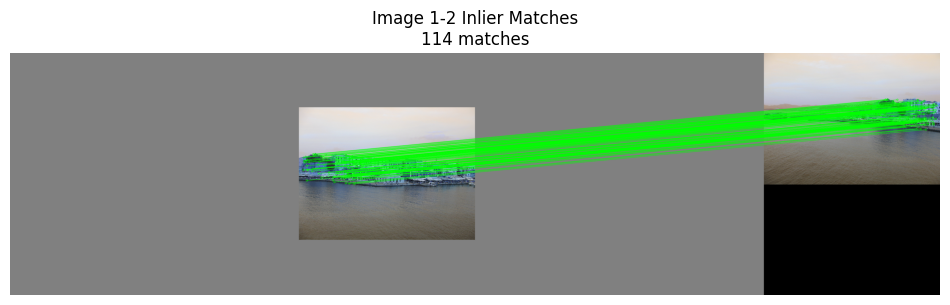

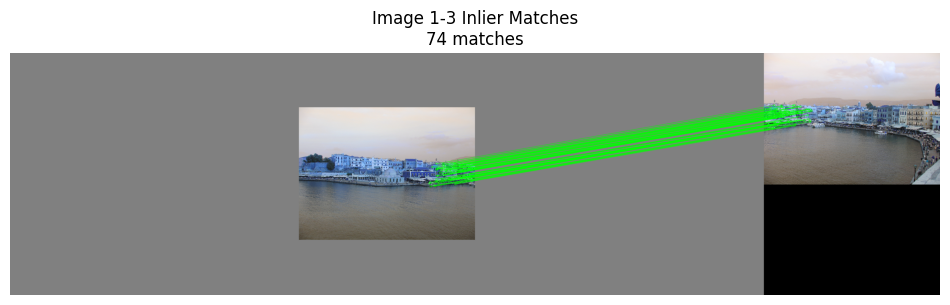

Stitching left image took: 0.09s
Stitching right image took: 0.09s


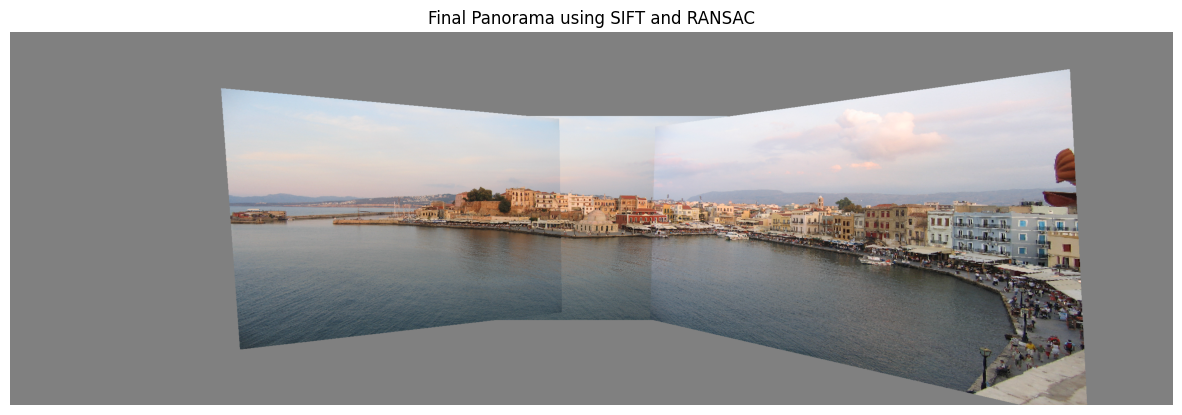

In [100]:
# Load data
data = sio.loadmat('../dataset/PracticalData.mat', squeeze_me=True)
im1 = data['im1']  # center image
im2 = data['im2']  # left image
im3 = data['im3']  # right image

# Convert images
im1_gray, im1_rgb = load_and_convert_image(im1)
im2_gray, im2_rgb = load_and_convert_image(im2)
im3_gray, im3_rgb = load_and_convert_image(im3)

#### Match Features and Estimate Homographies
print("\n=== Matching Features between Images ===")

# Match im1 and im2
t0 = time.time()
kp1_2, kp2, matches1_2 = detect_and_match(im1_gray, im2_gray)
H1to2, inliers1_2 = ransac_homography_manual(kp1_2, kp2, matches1_2)
print(f"Image 1-2 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_2)} inliers out of {len(matches1_2)} matches")

# Match im1 and im3
t0 = time.time()
kp1_3, kp3, matches1_3 = detect_and_match(im1_gray, im3_gray)
H1to3, inliers1_3 = ransac_homography_manual(kp1_3, kp3, matches1_3)
print(f"Image 1-3 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers1_3)} inliers out of {len(matches1_3)} matches")

# Visualize matches
visualize_matches(im1_rgb, im2_rgb, kp1_2, kp2, inliers1_2, "Image 1-2 Inlier Matches")
visualize_matches(im1_rgb, im3_rgb, kp1_3, kp3, inliers1_3, "Image 1-3 Inlier Matches")



# Stitch images
result = im1.copy()
result = stitch_image(result, im2, H1to2, 'left')
result = stitch_image(result, im3, H1to3, 'right')

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(result)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()


### Task: Try capture your own images and stich to panorama.
One panorama with at least 5 images is sufficient, the current example hardcodes 3 images, can you read from all images in a directory?

What else do you need to change to recover the complete panorama?

hint: You might need to make your canvas larger for more images.


=== Matching Features between Images ===
Best model found with 289 inliers.


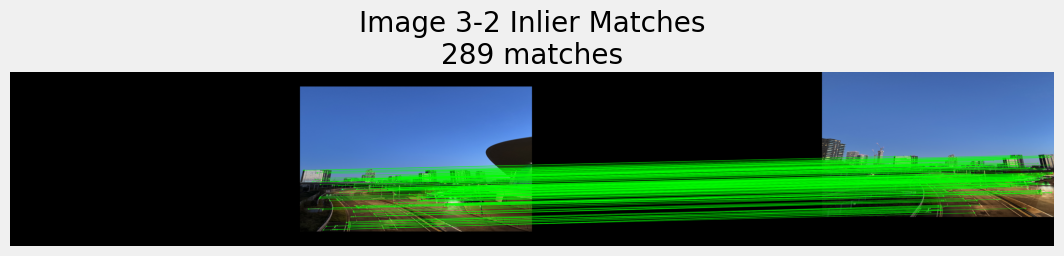

Stitching left image took: 0.18s
Image 3-2 matching time: 1.782 seconds
Found 289 inliers out of 306 matches
Best model found with 72 inliers.


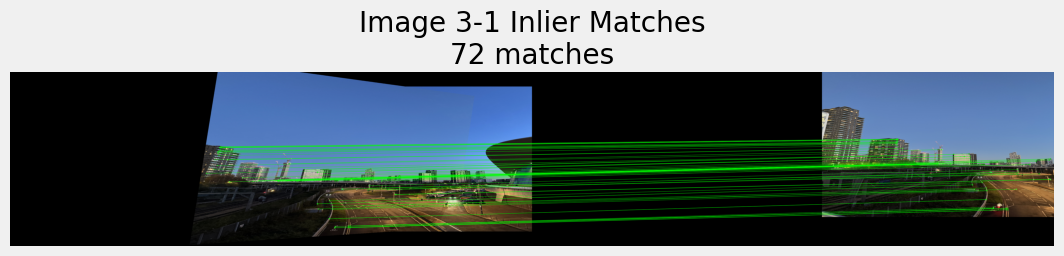

Stitching left image took: 0.19s
Image 3-1 matching time: 1.273 seconds
Found 72 inliers out of 90 matches
Best model found with 70 inliers.


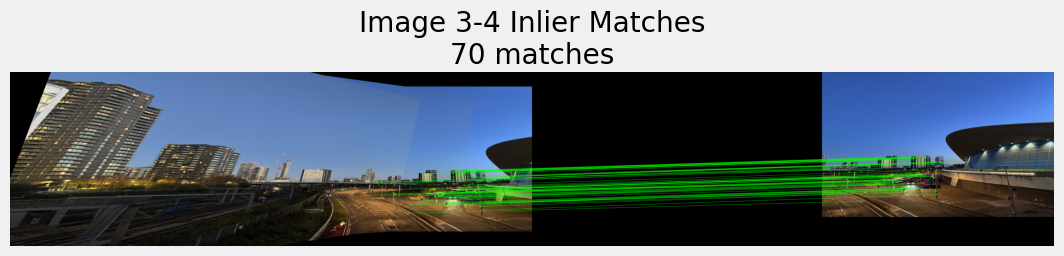

Stitching left image took: 0.21s
Image 3-4 matching time: 1.234 seconds
Found 70 inliers out of 86 matches
Best model found with 33 inliers.


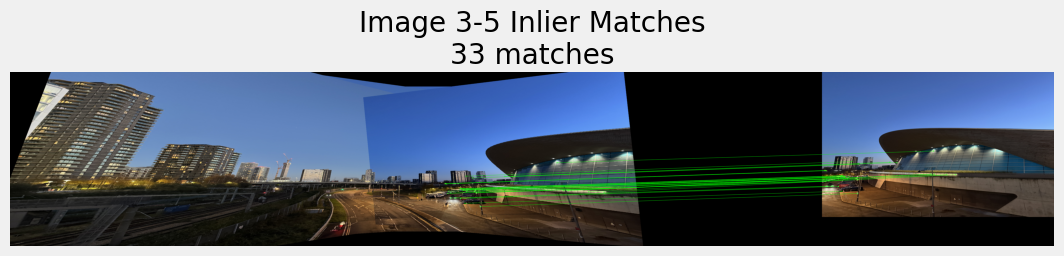

Stitching left image took: 0.20s
Image 3-5 matching time: 1.229 seconds
Found 33 inliers out of 56 matches


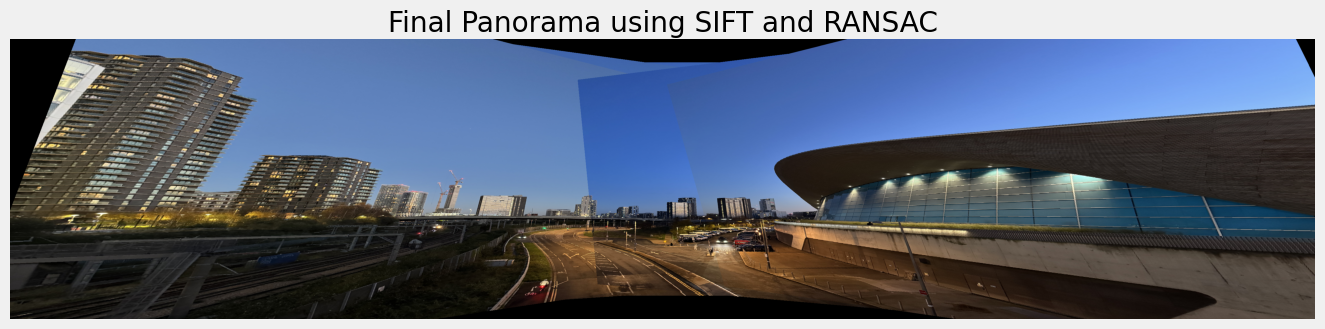

In [59]:
# Ibrahim's pics
im1 = cv2.imread('IMG_1450.jpg', cv2.IMREAD_COLOR)  # Read the second left image
im2 = cv2.imread('IMG_1451.jpg', cv2.IMREAD_COLOR)  # Read the first left image
im3 = cv2.imread('IMG_1452.jpg', cv2.IMREAD_COLOR)  # Read the center image
im4 = cv2.imread('IMG_1453.jpg', cv2.IMREAD_COLOR)  # Read the first right image
im5 = cv2.imread('IMG_1454.jpg', cv2.IMREAD_COLOR)  # Read the second right image

im1 = resize_image(im1)
im2 = resize_image(im2)
im3 = resize_image(im3)
im4 = resize_image(im4)
im5 = resize_image(im5)

# # Joe's pics
# im1 = cv2.imread('img1.png', cv2.IMREAD_COLOR)  # Read the second left image
# im2 = cv2.imread('img2.png', cv2.IMREAD_COLOR)  # Read the first left image
# im3 = cv2.imread('img3.png', cv2.IMREAD_COLOR)  # Read the center image
# im4 = cv2.imread('img4.png', cv2.IMREAD_COLOR)  # Read the first right image
# im5 = cv2.imread('img5.png', cv2.IMREAD_COLOR)  # Read the second right image

images = [im1, im2, im3, im4, im5]
center_image = im3

# Convert images
im1_gray, im1_rgb = load_and_convert_image(im1)
im2_gray, im2_rgb = load_and_convert_image(im2)
im3_gray, im3_rgb = load_and_convert_image(im3)
im4_gray, im4_rgb = load_and_convert_image(im4)
im5_gray, im5_rgb = load_and_convert_image(im5)

# Create a Canvas
h, w, c = center_image.shape
canvas_height = int(np.round(1.2*h))
canvas_width = int(w * len(images) * 0.7)
canvas = np.zeros((canvas_height,canvas_width,c), dtype= np.uint8)
center_start_x = (canvas_width // 2) - (w // 2)
center_start_y = (canvas_height // 2) - (h // 2)
canvas[center_start_y:center_start_y + h, center_start_x:center_start_x + w] = center_image
result = canvas

#### Match Features and Estimate Homographies
print("\n=== Matching Features between Images ===")

# Match im3 and im2
t0 = time.time()
result_gray, result_rgb = load_and_convert_image(result)
kp3_2, kp2, matches3_2 = detect_and_match(result_gray, im2_gray)
H3to2, inliers3_2 = ransac_homography_manual(kp3_2, kp2, matches3_2)

visualize_matches(result_rgb, im2_rgb, kp3_2, kp2, inliers3_2, "Image 3-2 Inlier Matches")
result = stitch_image(result, im2, H3to2, 'left')

print(f"Image 3-2 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers3_2)} inliers out of {len(matches3_2)} matches")

# Match im3 and im1
t0 = time.time()
result_gray, result_rgb = load_and_convert_image(result)
kp3_1, kp1, matches3_1 = detect_and_match(result_gray, im1_gray)
H3to1, inliers3_1 = ransac_homography_manual(kp3_1, kp1, matches3_1)

visualize_matches(result_rgb, im1_rgb, kp3_1, kp1, inliers3_1, "Image 3-1 Inlier Matches")
result = stitch_image(result, im1, H3to1, 'left')

print(f"Image 3-1 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers3_1)} inliers out of {len(matches3_1)} matches")

# Match im3 and im4
t0 = time.time()
result_gray, result_rgb = load_and_convert_image(result)
kp3_4, kp4, matches3_4 = detect_and_match(result_gray, im4_gray)
H3to4, inliers3_4 = ransac_homography_manual(kp3_4, kp4, matches3_4)

visualize_matches(result_rgb, im4_rgb, kp3_4, kp4, inliers3_4, "Image 3-4 Inlier Matches")
result = stitch_image(result, im4, H3to4, 'left')

print(f"Image 3-4 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers3_4)} inliers out of {len(matches3_4)} matches")

# # Match im3 and im5
t0 = time.time()
result_gray, result_rgb = load_and_convert_image(result)
kp3_5, kp5, matches3_5 = detect_and_match(result_gray, im5_gray)
H3to5, inliers3_5 = ransac_homography_manual(kp3_5, kp5, matches3_5)

visualize_matches(result_rgb, im5_rgb, kp3_5, kp5, inliers3_5, "Image 3-5 Inlier Matches")
result = stitch_image(result, im5, H3to5, 'left')

print(f"Image 3-5 matching time: {time.time()-t0:.3f} seconds")
print(f"Found {len(inliers3_5)} inliers out of {len(matches3_5)} matches")


result_final = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(result_final)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()


In [57]:
def create_panorama(images, images_gray, images_rgb):
    """Create a panorama from a list of images."""
    # Convert the first image
    base_image = images[0]
    h, w, c = base_image.shape

# Create a Canvas
    canvas_height = int(np.round(1.2*h))
    canvas_width = int(w * len(images) * 0.7)
    canvas = np.zeros((canvas_height,canvas_width,c), dtype= np.uint8)
    center_start_x = (canvas_width // 2) - (w // 2)
    center_start_y = (canvas_height // 2) - (h // 2)
    canvas[center_start_y:center_start_y + h, center_start_x:center_start_x + w] = base_image

    result = canvas 

    for i in range(1, len(images)):
        result_gray, result_rgb = load_and_convert_image(result)
        # Load and convert the next image
        next_image, next_gray, next_rgb= images[i], images_gray[i], images_rgb[i]

        # Match features and estimate homography
        kp_base, kp_next, matches = detect_and_match(result_gray, next_gray)
        print(f"Matching image {i} - Found {len(matches)} matches")
        H, inliers = ransac_homography_manual(kp_base, kp_next, matches)

        print(f"Matching image {i} - Found {len(inliers)} inliers out of {len(matches)} matches")

        visualize_matches(next_rgb, result_rgb, kp_base, kp_next, inliers, f"Image {i} Inlier Matches")

        # Stitch the current panorama with the next image
        result = stitch_image(result, next_image, H, 'left')  # Adjust direction if needed

    return result

Matching image 1 - Found 306 matches
Best model found with 287 inliers.
Matching image 1 - Found 287 inliers out of 306 matches


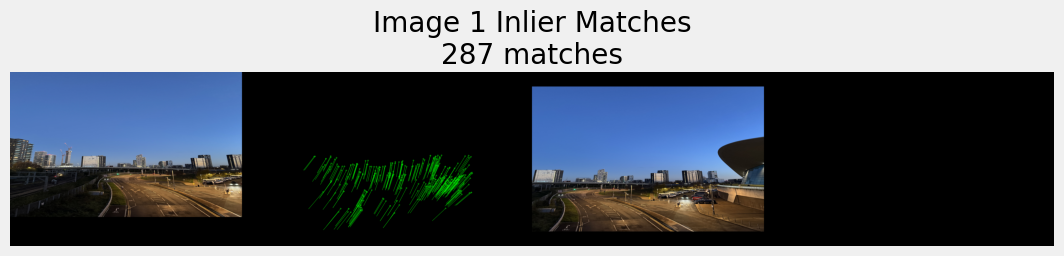

Stitching left image took: 0.18s
Matching image 2 - Found 78 matches
Best model found with 64 inliers.
Matching image 2 - Found 64 inliers out of 78 matches


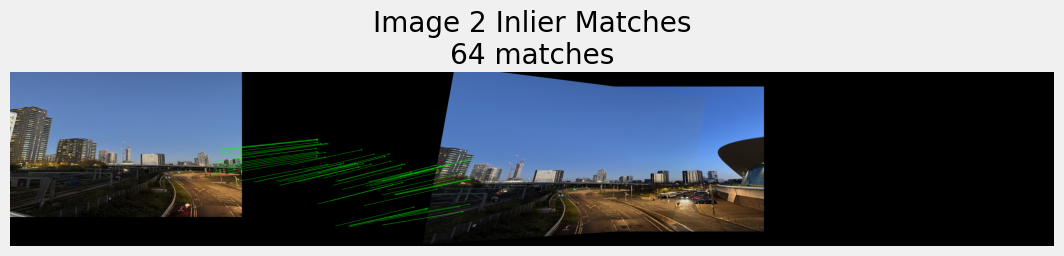

Stitching left image took: 0.22s
Matching image 3 - Found 96 matches
Best model found with 84 inliers.
Matching image 3 - Found 84 inliers out of 96 matches


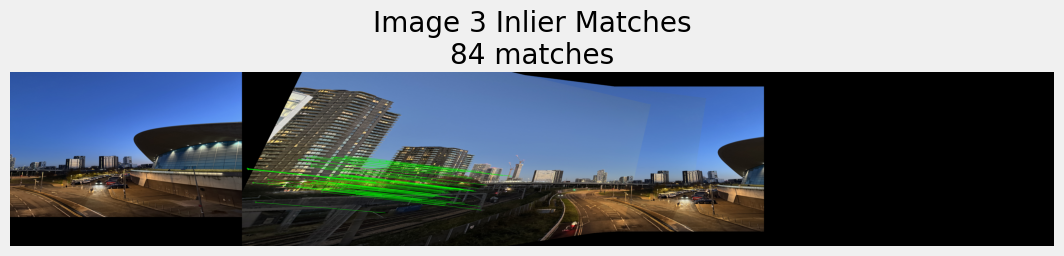

Stitching left image took: 0.17s
Matching image 4 - Found 51 matches
Best model found with 28 inliers.
Matching image 4 - Found 28 inliers out of 51 matches


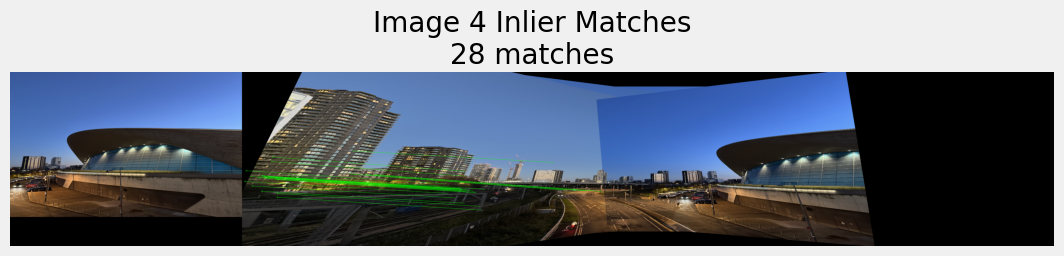

Stitching left image took: 0.19s
Panorama creation time: 5.283 seconds


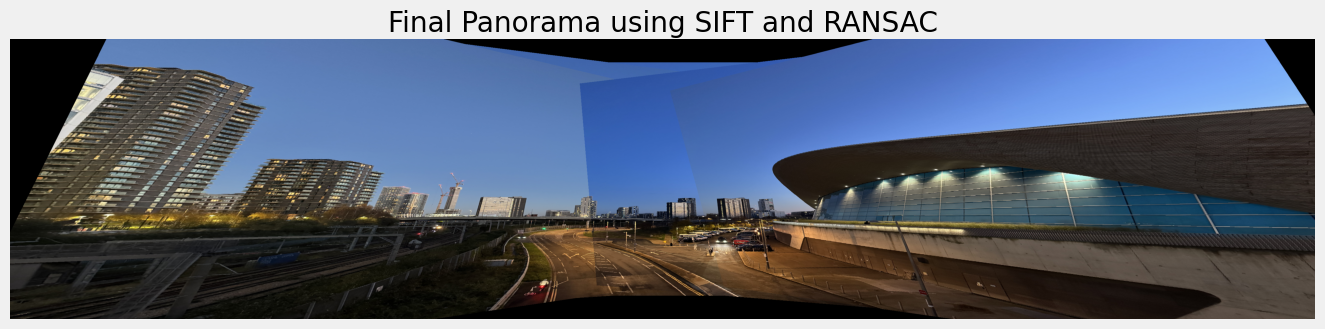

In [58]:
# Ibrahim's pics
im1 = cv2.imread('IMG_1450.jpg', cv2.IMREAD_COLOR)  # Read the second left image
im2 = cv2.imread('IMG_1451.jpg', cv2.IMREAD_COLOR)  # Read the first left image
im3 = cv2.imread('IMG_1452.jpg', cv2.IMREAD_COLOR)  # Read the center image
im4 = cv2.imread('IMG_1453.jpg', cv2.IMREAD_COLOR)  # Read the first right image
im5 = cv2.imread('IMG_1454.jpg', cv2.IMREAD_COLOR)  # Read the second right image

im1 = resize_image(im1)
im2 = resize_image(im2)
im3 = resize_image(im3)
im4 = resize_image(im4)
im5 = resize_image(im5)

# Convert images
im1_gray, im1_rgb = load_and_convert_image(im1)
im2_gray, im2_rgb = load_and_convert_image(im2)
im3_gray, im3_rgb = load_and_convert_image(im3)
im4_gray, im4_rgb = load_and_convert_image(im4)
im5_gray, im5_rgb = load_and_convert_image(im5)



images, images_gray, images_rgb = [im3, im2, im1, im4, im5], [im3_gray, im2_gray, im1_gray, im4_gray, im5_gray], [im3_rgb, im2_rgb, im1_rgb, im4_rgb, im5_rgb]

# Create the panorama
t0 = time.time()
panorama = create_panorama(images,images_gray,images_rgb)
panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
print(f"Panorama creation time: {time.time()-t0:.3f} seconds")

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(panorama_rgb)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()

In [55]:
def create_panorama(images):
    """Create a panorama from 5 images using SIFT and RANSAC with added padding."""
    
    # Load images
    if len(images) == 5:
        im1_gray, im1_rgb = load_and_convert_image(images[0])
        im2_gray, im2_rgb = load_and_convert_image(images[1])
        im3_gray, im3_rgb = load_and_convert_image(images[2])  # Center image
        im4_gray, im4_rgb = load_and_convert_image(images[3])
        im5_gray, im5_rgb = load_and_convert_image(images[4])

    else:
        raise ValueError("Not enough images in the directory to create a panorama!")
    
    # Convert the first image
    base_image = images[2]
    base_image_gray, base_image_rgb = load_and_convert_image(base_image)
    h, w, c = base_image.shape

# Create a Canvas
    canvas_height = int(np.round(1.2*h))
    canvas_width = int(w * len(images) * 0.7)
    canvas = np.zeros((canvas_height,canvas_width,c), dtype= np.uint8)
    center_start_x = (canvas_width // 2) - (w // 2)
    center_start_y = (canvas_height // 2) - (h // 2)
    canvas[center_start_y:center_start_y + h, center_start_x:center_start_x + w] = base_image

    result = canvas 

    result_gray, result_rgb = load_and_convert_image(result)

    # --- Stitch left images ---
    kp1_2, kp2, matches1_2 = detect_and_match(im1_gray, im2_gray)
    H1to2, inliers1_2 = ransac_homography_manual(kp1_2, kp2, matches1_2)
    result_left = stitch_image(im1, im2, H1to2, direction="left")

    # return result_left

    # --- Stitch left result to center ---
    result_left_gray, result_left_rgb = load_and_convert_image(result_left)
    kp_left, kp_center, matches_left_center = detect_and_match(result_gray, result_left_gray)
    #visualize_matches(result_left_rgb, result_rgb, kp_left, kp_center, matches_left_center, title="Matches for Left to Center")
    H_left_to_center, inliers_left_center = ransac_homography_manual(kp_left, kp_center, matches_left_center)
    result_center = stitch_image(result, result_left, H_left_to_center, direction="left")

    # return result_center  

    # --- Stitch right images ---
    kp4_5, kp5, matches4_5 = detect_and_match(im4_gray, im5_gray)
    H4to5, inliers4_5 = ransac_homography_manual(kp4_5, kp5, matches4_5)
    result_right = stitch_image(im4, im5, H4to5, direction="right")

    # return result_right
     
    # --- Stitch right result to center ---
    result_center_gray, result_center_rgb = load_and_convert_image(result_center)
    result_right_gray, result_right_rgb = load_and_convert_image(result_right)
    kp_right, kp_center, matches_right_center = detect_and_match(result_center_gray, result_right_gray)
    #visualize_matches(result_center_rgb, result_right_rgb, kp_right, kp_center, matches_right_center, title="Matches for Right to Center")
    H_right_to_center, inliers_right_center = ransac_homography_manual(kp_right, kp_center, matches_right_center)
    result_center = stitch_image(result_center_rgb, result_right_rgb, H_right_to_center, direction="right")

    return result_center



Best model found with 149 inliers.
Stitching left image took: 0.05s
Best model found with 30 inliers.
Stitching left image took: 0.21s
Best model found with 242 inliers.
Stitching right image took: 0.05s
Best model found with 75 inliers.
Stitching right image took: 0.16s
Panorama creation time: 3.248 seconds


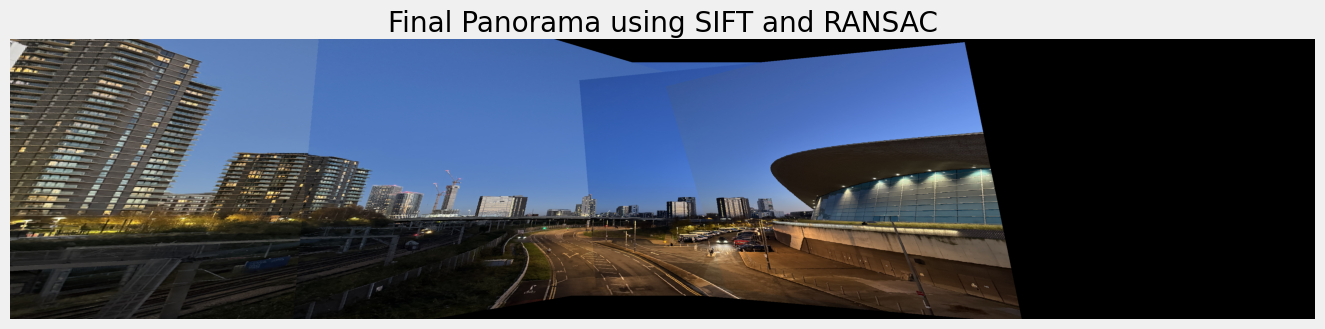

In [56]:
# Ibrahim's pics
im1 = cv2.imread('IMG_1450.jpg', cv2.IMREAD_COLOR)  # Read the second left image
im2 = cv2.imread('IMG_1451.jpg', cv2.IMREAD_COLOR)  # Read the first left image
im3 = cv2.imread('IMG_1452.jpg', cv2.IMREAD_COLOR)  # Read the center image
im4 = cv2.imread('IMG_1453.jpg', cv2.IMREAD_COLOR)  # Read the first right image
im5 = cv2.imread('IMG_1454.jpg', cv2.IMREAD_COLOR)  # Read the second right image

im1 = resize_image(im1)
im2 = resize_image(im2)
im3 = resize_image(im3)
im4 = resize_image(im4)
im5 = resize_image(im5)

# Joe's pics
# im1 = cv2.imread('img1.png', cv2.IMREAD_COLOR)  # Read the second left image
# im2 = cv2.imread('img2.png', cv2.IMREAD_COLOR)  # Read the first left image
# im3 = cv2.imread('img3.png', cv2.IMREAD_COLOR)  # Read the center image
# im4 = cv2.imread('img4.png', cv2.IMREAD_COLOR)  # Read the first right image
# im5 = cv2.imread('img5.png', cv2.IMREAD_COLOR)  # Read the second right image

images = [im1, im2, im3, im4, im5]

# Create the panorama
t0 = time.time()
panorama = create_panorama(images)
panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
print(f"Panorama creation time: {time.time()-t0:.3f} seconds")

# Display final panorama
plt.figure(figsize=(15, 8))
plt.imshow(panorama)
plt.title("Final Panorama using SIFT and RANSAC")
plt.axis('off')
plt.show()